*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Regression

TODO: intro

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/chapters/regression.ipynb).

In [1]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url, filename=None):
    if filename is None:
        filename = basename(url)
        
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

In [4]:
from utils import set_precision

set_precision(4)

## Regression as Minimization

Before we think of regression as a linear algebra problem, let's start with minimization.
Specifically, we'll start with **least squares regression**, which minimizes the sum of squared errors.

As the smallest example, I'll construct a predictor, `x`, and a response variable, `y` -- sometimes called independent and dependent variables.

In [5]:
x = np.array([2, 1, 0]) + 0.1
y = 0.5 + 0.8 * x + [-0.1, -0.2, 0.3]
y

array([2.08, 1.18, 0.88])

A natural way to visualize this dataset is to plot `y` versus `x`.

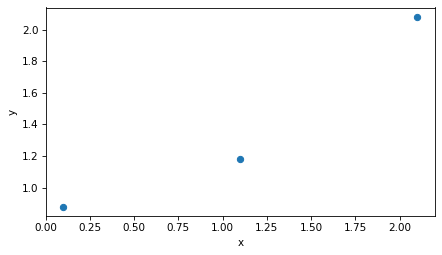

In [6]:
plt.plot(x, y, 'o')
decorate(xlabel='x', ylabel='y')

There's no line that goes through all three points, so we'll find a line of **best fit**.
First we'll construct the **design matrix**, which contains two columns: the first is all `1`s, and the second is the predictor, `x`.

In [7]:
from sympy import Matrix

X = np.column_stack((np.ones_like(x), x))
Matrix(X)

Matrix([
[1.0, 2.1],
[1.0, 1.1],
[1.0, 0.1]])

Now the goal is to find a vector of parameters, `beta`, the contains the intercept and slope of the fitted line.
We'll start with a not very good guess about the line of best fit.

In [8]:
beta = np.array([1, 0.4])

To see how good that choice is, we can evaluate the line at each location in `x`.

In [9]:
y_fit = X @ beta

The errors, also called **residuals**, are the vertical distances between the actual values, `y`, and the fitted line. 

In [10]:
r = y - y_fit
r

array([ 0.24, -0.26, -0.16])

Here's what that looks like.
The dots are the actual values, the solid line is the not-very-good fit, and the vertical dotted lines show the residuals.

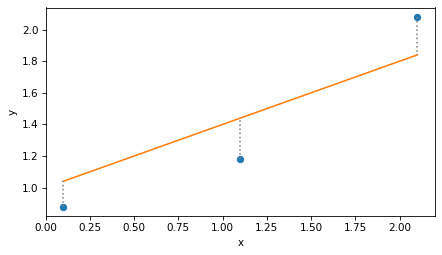

In [11]:
plt.plot(x, y, 'o')
plt.plot(x, y_fit)
plt.vlines(x, y, y_fit, ls=':', color='gray')
decorate(xlabel='x', ylabel='y')

To compute the **residual sum of squares**, we use array operations.

In [12]:
np.sum(r**2)

0.1508

Or equivalently, we can compute the dot product of the residuals.

In [13]:
r @ r

0.1508

Here's a function that takes a hypothetical vector of coefficients, `beta`, and returns the residual sum of squares, `rss`.

In [14]:
def rss_func(beta, X, y):
    r = y - X @ beta
    return np.dot(r, r)

Here's the result for the example.

In [15]:
rss_func(beta, X, y)

0.1508

That function works with the `minimize` function from SciPy to efficiently search for the value of `beta` that minimizes `rss`.

In [16]:
from scipy.optimize import minimize

result = minimize(rss_func, beta, args=(X, y))
result.message

'Optimization terminated successfully.'

The message indicates that the iterative search converged to a minimum.
`nfev` is the number of function evaluations -- that is, the number of times `minimize` called `rss_func` with different values of `beta`.

In [17]:
result.nfev

15

And here's the result, which we'll call `beta_hat` because the conventional notation for this result is $\hat{\beta}$, and the caret is almost universally called a "hat".

In [18]:
beta_hat = result.x
beta_hat

array([0.72, 0.6 ])

We can confirm that this value of `beta` yields a lower `rss` than the initial guess. 

In [19]:
rss_func(beta_hat, X, y)

0.0600

If we use `beta_hat` to compute fitted values, the result is called `y_hat`.

In [20]:
y_hat = X @ beta_hat

And here's what the least squares fit looks like.

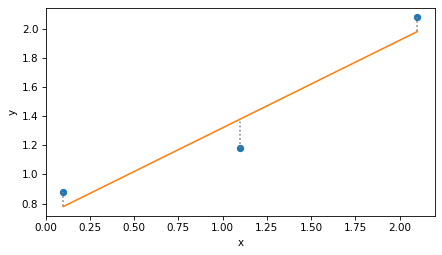

In [21]:
plt.plot(x, y, 'o')
plt.plot(x, y_hat)
plt.vlines(x, y, y_hat, ls=':', color='gray')
decorate(xlabel='x', ylabel='y')

Again, the dotted lines represent the residuals, `r`, and the residual sum of squares is the dot product of `r` with itself.

In [22]:
r = y - y_hat
r @ r

0.0600

To be honest, minimization is not a terrible way to solve regression problems, and it generalizes easily to other definitions of "best" and other kinds of regression.
But if we write linear least squared regression as an overconstrained matrix equation, this formulation has an elegant and efficient solution. 

## Projection

Now let's do some linear algebra.
We'll pull out the columns of the design matrix, `X`, as three-dimensional vectors `v1` and `v2`.

In [23]:
v1, v2 = np.transpose(X)
v1

array([1., 1., 1.])

In [24]:
v2

array([2.1, 1.1, 0.1])

The linear combinations of these vector span a two dimensional plane in three dimensions.
The following figure shows this plane.

It also shows the response variable, `y`, which we can also think of as a vector in three dimensions, as well as the vector of fitted values, `y_hat`.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_vectors(
    vectors,
    origin=None,
    start=0,
    end=None,
    scale=1,
    labels=None,
    label_pos=None,
    **options
):
    """Plot a set of vectors in 2D or 3D.

    Args:
        vectors: list of vectors or array with one row per vector (shape: (N, 2) or (N, 3))
        origin: list of vectors or array with one row per vector (default: all at (0,0) or (0,0,0))
        start: integer slice index
        end: integer slice index
        scale: factor to multiply vectors
        labels: list of string labels
        label_pos: list of locations as integer clock positions (only for 2D)
        options: passed to plt.quiver
    """
    vectors = np.asarray(vectors) * scale
    dim = vectors.shape[1]  # Determine 2D vs. 3D

    if origin is None:
        origin = np.zeros_like(vectors)
    else:
        origin = np.asarray(origin)

    underride(
        options,
        color="C0",
        alpha=0.6,
    )

    ax = plt.gca()
    if dim == 2:
        # 2D case using plt.quiver
        us, vs = vectors[start:end].T
        xs, ys = origin[start:end].T

        underride(
            options,
            angles="xy",
            scale_units="xy",
            scale=1,
        )

        ax.scatter(xs, ys, s=0)
        ax.scatter(xs + us, ys + vs, s=0)
        ax.quiver(xs, ys, us, vs, **options)

    elif dim == 3:
        # 3D case using ax.quiver
        us, vs, ws = vectors[start:end].T
        xs, ys, zs = origin[start:end].T

        underride(
            options,
            arrow_length_ratio=0.1,
        )

        ax.scatter(xs, ys, zs, s=0)
        ax.scatter(xs + us, ys + vs, zs + zs, s=0)
        ax.quiver(xs, ys, zs, us, vs, ws, **options)

    else:
        raise ValueError("Only 2D and 3D vectors are supported.")

In [26]:
def plot_plane(v1, v2, origin=None, **options):
    """Plot a shaded plane spanned by two vectors in 3D.

    Args:
        v1: First vector defining the plane (array-like, shape (3,))
        v2: Second vector defining the plane (array-like, shape (3,))
        origin: Origin point of the plane (default: [0, 0, 0])
        options: Passed to plot_surface (e.g., color, alpha)
    """
    v1, v2 = np.asarray(v1), np.asarray(v2)

    if len(v1) != 3 or len(v2) != 3:
        raise ValueError("plot_plane requires 3D vectors.")

    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.asarray(origin)

    # Generate a mesh grid for the plane
    u = [0, 1]
    v = [0, 1]
    U, V = np.meshgrid(u, v)

    # Plane equation: P = origin + U * v1 + V * v2
    X = origin[0] + U * v1[0] + V * v2[0]
    Y = origin[1] + U * v1[1] + V * v2[1]
    Z = origin[2] + U * v1[2] + V * v2[2]

    underride(options, color="gray", alpha=0.3)

    # Plot the plane
    ax = plt.gca()
    ax.plot_surface(X, Y, Z, **options)

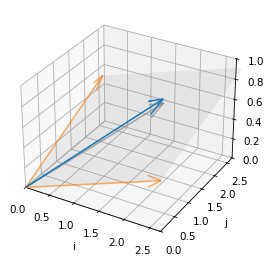

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

plot_plane(v1, v2, alpha=0.08)
plot_vectors([v1, v2], color='C1')
plot_vectors([y], alpha=1)
plot_vectors([y_hat], color='gray')

lim = [0, 2.7]
decorate(xlim=lim, ylim=lim, zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

`y` does not fall in the plane, which means it cannot be expressed as a linear combination of the columns of `X`.

But `y_hat` *does* fall in the plane, because it is a combination of the columns of `X` -- specifically, `y_hat = X @ beta`.

The difference between `y` and `y_hat` is the residual, `r`, which we can also think of as a vector in this space.
This vector has two important properties.
First, the length of `r`, squared, is the residual sum of squares.

In [29]:
from utils import norm

norm(r) ** 2

0.0600

Second, `r` is perpendicular to the columns of `X`, which we can confirm by showing that their dot product is close to zero.

In [30]:
X.T @ r

array([-7.9582e-09, -7.7054e-09])

This result means that `y_hat`, the fitted values that minimize RSS, is the **projection** of `y` onto the plane defined by `v1` and `v2` -- that is, the vector in the plane that's closest to `y`.

This insight is the key to an efficient way to compute `y_hat`, using QR decomposition.


## QR Decomposition

QR composition is similar to LU decomposition, which we used to solve systems of linear equations efficiently.
In LU decomposition, we express a matrix, `A`, as the product of two matrices, one lower-diagonal and one upper-diagonal.

In QR decomposition, we'll express the design matrix, `X`, as the product of two matrices, one **orthonormal** and one upper diagonal.

To explain what an orthonormal matrix is, and why it is useful, we'll use the NumPy function `qr` to compute the decomposition.
In the next section we'll see how this function works.

In [31]:
Q, R = np.linalg.qr(X)

The results are two matrices. `Q` is the same size as `X`.

In [32]:
Q

array([[-5.7735e-01,  7.0711e-01],
       [-5.7735e-01,  5.5511e-17],
       [-5.7735e-01, -7.0711e-01]])

And `R` has the same number of columns as `X`, but it's square and upper triangular.

In [33]:
R

array([[-1.7321, -1.9053],
       [ 0.    ,  1.4142]])

First let's confirm that $Q R = X$. 

In [34]:
np.allclose(Q @ R, X)

True

Now if `Q` is orthonormal, the "ortho" part means that the columns are perpendicular to each other, and the "normal" part means the norm of the columns is `1`.
We can confirm both by computing the dot product of the columns with themselves.

In [35]:
Matrix(Q.T @ Q)

Matrix([
[                  1.0, -1.16219581322268e-16],
[-1.16219581322268e-16,                   1.0]])

The off-diagonal elements are close to zero, which confirms that the columns are orthogonal to each other, and the diagonal elements are 1, which confirms that their norm is 1.

But also notice that the product of $Q^T$ and $Q$ is the identity matrix, $I$, which means that $Q^T$ is the inverse of $Q$.

And *that* means we can solve the equation 

$Q \beta' = y$ 

by multiplying both sides by $Q^T$, which yields 

$Q^T Q \beta' = Q^T y$, 

which yields 

$\beta' = Q^T y$.

In [36]:
beta_prime = Q.T @ y
beta_prime

array([-2.3902,  0.8485])

And why would we want to solve $Q \beta' = y$?
Because the result is the coordinates of $\hat{y}$ in the span of $Q$.
We can confirm that by multiplying those coordinates by the columns of $Q$.

In [37]:
y_hat = Q @ beta_prime
y_hat

array([1.98, 1.38, 0.78])

And the result is the same as the `y_hat` we computed by minimizing RSS.
Combining the last two steps, we could have computed.

In [38]:
y_hat = Q @ Q.T @ y
y_hat

array([1.98, 1.38, 0.78])

Instead of multiplying `y` by `Q.T` first, we could multiply `Q` and `Q.T` first.

In [39]:
P = Q @ Q.T
P

array([[ 0.8333,  0.3333, -0.1667],
       [ 0.3333,  0.3333,  0.3333],
       [-0.1667,  0.3333,  0.8333]])

The result is a projection matrix that projects any vector into the span of `Q`.

In [40]:
y_hat = P @ y
y_hat

array([1.98, 1.38, 0.78])

Normally we would not compute `P` explicitly, but it is useful for confirming an important property of `Q`, which is that it has the same span as `X`.
We can show that by projecting the columns of `X` onto `Q`.

In [41]:
P @ X

array([[1. , 2.1],
       [1. , 1.1],
       [1. , 0.1]])

And confirming that the result is `X`.

In [42]:
np.allclose(P @ X, X)

True

Which shows that the plane spanned by `Q` is the same as the plane spanned by `X`.
Here's what that looks like in the diagram.

In [43]:
q1, q2 = Q.T

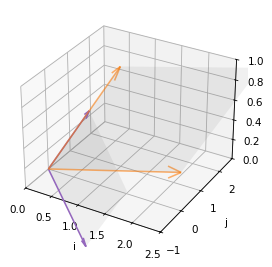

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

plot_plane(v1, v2, alpha=0.08)
plot_plane(-q1, q2, alpha=0.08)
plot_vectors([v1, v2], color='C1')
plot_vectors([-q1, q2], color='C4', alpha=1)

lim = [0, 2.5]
decorate(xlim=lim, ylim=[-1, 2.7], zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

Because of the limitations of 3D visualization, it might not be obvious that the two shaded areas are in the same plane -- but they are.

This property is important because it means that projecting `y` onto `Q` is the same as projecting `y` onto `X`, which minimizes RSS -- so we are almost there!

The last step is to use `beta_prime`, which contains the coordinates of `y_hat` in terms of the columns of `Q`, to `beta`, which contains coordinates of `y_hat` in terms of the columns of `X`.
So how do we do that?

We have found $\beta'$ such that $Q \beta' = \hat{y}$, and we want $\beta$ such that $X \beta = \hat{y}$. Setting the left sides equal, we get

$X \beta = Q \beta'$

Replacing $X$ with $QR$ we have

$Q R \beta = Q \beta'$

If we multiplying through by $Q^{-1}$, we can cancel $Q$ on both sides, leaving

$R \beta = \beta'$

So we can find $\beta$ by solving this equation.

Since `R` is upper triangular, we can use `solve_triangular`, which is more efficient that the more general `solve` function.
The argument `lower=False` indicates that `R` is upper triangular.

In [45]:
from scipy.linalg import solve_triangular

beta_qr = solve_triangular(R, beta_prime, lower=False)
beta_qr

array([0.72, 0.6 ])

And the result is the same as the `beta` we computed by minimization.

It took a few steps to get here, but now we can write the whole process in just two lines.

In [46]:
def lstsq(X, y):
    Q, R = np.linalg.qr(X)
    beta = solve_triangular(R, Q.T @ y, lower=False)
    return beta

And we get the same result.

In [47]:
lstsq(X, y)

array([0.72, 0.6 ])

SciPy provides a similar function with additional capabilities.

In [48]:
import scipy

beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')

The argument `lapack_driver='gelsy'` specifies which function to use.
The "ge" part of the name indicates that the function works with general matrices -- not necessarily symmetric, for example.
The "ls" part means it computes least squares.
And "y" indicates the variant that uses QR decomposition.

The first return value is `beta` again. 

In [49]:
beta

array([0.72, 0.6 ])

The second and fourth return values are used by other functions, but not `gelsy`.
And the third return value is the rank of the design matrix, which is usually the number of columns in `X`.

In [50]:
rank

2

If the columns are dependent -- that is, if some are linear combinations of others -- the rank might be lower.
We'll see an example of that soon, but first we have a loose end to tie up: how do we compute the QR decomposition?

## Orthonormalization

QR decomposition provides an efficient way to compute a least squares solution to an overconstrained system.
Now let's see how to do the decomposition.
The process turns out to be simpler than you might expect.

We'll start by unpacking the columns of `X`.

In [51]:
from utils import norm, normalize

v1, v2 = X.T

Now the goal is to find two orthogonal unit vectors, `q1` and `q2`, that span the same plane as `v1` and `v2`.
To compute `q1` we'll compute a unit vector with the same direction as `v1`.

In [52]:
q1 = normalize(v1)
q1

array([0.5774, 0.5774, 0.5774])

To compute `q2`, we'll subtract from `v2` the part of of `v2` parallel to `q1`, leaving only the part of `v2` perpendicular to `q1`.

In [55]:
from utils import vector_projection

v2_perp = v2 - vector_projection(v2, q1)

Then we normalize the perpendicular part.

In [56]:
q2 = normalize(v2_perp)
q2

array([ 0.7071,  0.    , -0.7071])

If we pack `q1` and `q2` into a matrix, we get the same `Q` computed by NumPy.

In [59]:
Q = np.column_stack([q1, q2])
Q

array([[ 0.5774,  0.7071],
       [ 0.5774,  0.    ],
       [ 0.5774, -0.7071]])

And we can confirm that `Q.T @ Q = I`, which means that `Q` is orthonormal.

In [60]:
Q.T @ Q

array([[ 1.0000e+00, -1.7796e-17],
       [-1.7796e-17,  1.0000e+00]])

The process we just followed is called **Gram-Schmidt orthonormalization**.
If there are more than two vectors we can repeat the process.
For the third vector, we subtract off the parts parallel to `q1` and `q2`, and normalize what's left.

The following function implements this process for a matrix with any number of columns.

In [61]:
def gram_schmidt(X):
    basis = []
    for v in X.T.copy():
        for q in basis:
            v -= vector_projection(v, q)
        basis.append(normalize(v))
    return np.transpose(basis)

And we can confirm it works for `X`.

In [62]:
gram_schmidt(X)

array([[ 0.5774,  0.7071],
       [ 0.5774,  0.    ],
       [ 0.5774, -0.7071]])

The previous function is meant to demonstrate the process clearly, but it only computes `Q`.
The following function also computes `R`, so it is a little more complicated.

In [63]:
def gram_schmidt(X):
    m, n = X.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = X[:, j].copy()
        for i in range(j):
            R[i, j] = X[:, j] @ Q[:, i]
            v -= R[i, j] * Q[:, i]
            
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    
    return Q, R

In `R`, the off-diagonal element of `R[i, j]` records the scalar projection of column `j` from `X` into column `i` from `Q`.
And the diagonal element `R[j, j]` records the factor used to normalize column `j` from `Q`.

In [65]:
Q, R = gram_schmidt(X)

array([[ 5.7735e-01,  7.0711e-01],
       [ 5.7735e-01, -1.5701e-16],
       [ 5.7735e-01, -7.0711e-01]])

Let's confirm that this function computes the same `R` we got from NumPy.

In [66]:
R

array([[1.7321, 1.9053],
       [0.    , 1.4142]])

And that `Q R = X`.

In [67]:
np.allclose(Q @ R, X)

True

That's it! Computing the QR decomposition is efficient, and not especially complicated.

At this point, you might be tired of the small example we've been working with.
So let's see what we can do with real data.

## Multiple Regression

Do people get more conservative as they get older?
To find out, we'll use data from the General Social Survey (GSS) to explore the relationship between political ideology and age, also considering changes over time and differences between generations.

We'll use **multiple regression**, which involves more than one predictor, and we'll see the problems that arise if the predictors are strongly correlated.


The following cell downloads an excerpt of GSS data collected between 1974 and 2024.

In [101]:
download('https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_extract_2024_1.hdf')

We can read the data into a Pandas DataFrame.

In [102]:
gss = pd.read_hdf('gss_extract_2024_1.hdf')
gss.shape

(75699, 62)

The DataFrame contains one row for each of the 75,699 respondents who have participated in the GSS, and one column for each of the variables in this excerpt.

We'll select only the columns we need for this example and drop any rows with missing data in those columns.


In [103]:
columns = ['polviews', 'year', 'cohort']
subset = gss.dropna(subset=columns)[columns]

The `year` column records the year each respondent was interviewed, and the `cohort` column records their year of birth (sometimes called "birth cohort").
So we can compute the age of each respondent when they were interviewed.

In [104]:
subset['age'] = subset['year'] - subset['cohort']

The describe method computes summary statistics for these variables.

In [105]:
subset.describe()

,polviews,year,cohort,age
count,65239.0000,65239.0000,65239.0000,65239.0000
mean,4.1086,1999.9547,1954.8059,45.1488
std,1.4057,15.2522,21.9236,17.2269
min,1.0000,1974.0000,1885.0000,18.0000
25%,3.0000,1987.0000,1941.0000,31.0000
50%,4.0000,2000.0000,1956.0000,43.0000
75%,5.0000,2014.0000,1969.0000,58.0000
max,7.0000,2024.0000,2006.0000,90.0000


The range of `year` is from 1974 to 2024.
The range of `cohort` is from 1885 to 2006.
The range of `age` is from 18 to 90.

`polviews` records responses to this question

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?


The responses are recorded in one of seven categories.

| Number | Political Ideology |
|--------|-------------------|
| 1 | Extremely liberal |
| 2 | Liberal |
| 3 | Slightly liberal |
| 4 | Moderate, middle of the road |
| 5 | Slightly conservative |
| 6 | Conservative |
| 7 | Extremely conservative |

The average of the numerical codes is 4.1, which is close to "middle of the road".
Higher numbers are more conservative, and lower numbers are more liberal.

In [70]:
import numpy as np

def add_constant(X):
    """Add an intercept column of ones to a 1D or 2D array-like X.
    
    Args:
        X: array-like, shape (n,) or (n, m)
    
    Returns:
        array of shape (n, m+1) with a column of ones prepended
    """
    X = np.asarray(X)

    # If X is 1D, make it a column vector
    if X.ndim == 1:
        X = X[:, np.newaxis]

    n = X.shape[0]
    ones = np.ones((n, 1))
    return np.column_stack([ones, X])


We can use least squares regression to see how the responses are related to age and other variables.
We'll assign the values of this response variable to `y`.

In [71]:
response = 'polviews'
y = subset[response]

And for the first version of the model we'll select `age` as the only predictor.

In [72]:
predictor = 'age'
means_age = subset.groupby(predictor)[response].mean()

We can get a sense of the relationship between these variables by computing the mean of the response variable in each age group.

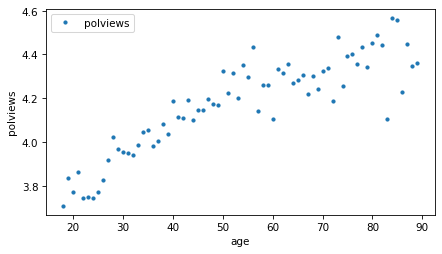

In [73]:
means_age.plot(style='.')
decorate(xlabel=predictor, ylabel=response)

The average increases with age, which means that older people consider themselves more conservative.
But the difference is not very big -- the average among people in their 20s, when they were interviewed, is only slightly left of center, and people in their 90s are about halfway between "middle of the road" and "slightly conservative", on average. 

Let's fit a line to this data.
We'll use `add_constant` to make a design matrix, `X`, that contains the single predictor and a columns of ones.

In [74]:
predictors = [predictor]
X = add_constant(subset[predictors])
X.shape

(65239, 2)

And we'll use SciPy to compute the least squares fit.

In [75]:
beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')
rank, beta

(2, array([3.6415, 0.0104]))

The rank is `2`, which indicates that the two columns of `X` are independent.
We can interpret the elements of `beta` as an intercept and slope.
The slope is about 0.01, which means that a difference of one year in age is associated with a difference of 0.01 in the average response.
The intercept is the value of the fitted line when `age=0` -- but the fitted line doesn't mean much in this part of the domain.

It makes more sense to evaluate the fitted line over the relevant range of ages, from 18 to 90.

In [76]:
fit_x = np.arange(18, 90)
fit_y = add_constant(fit_x) @ beta

Here's what the line looks like compared to the data.

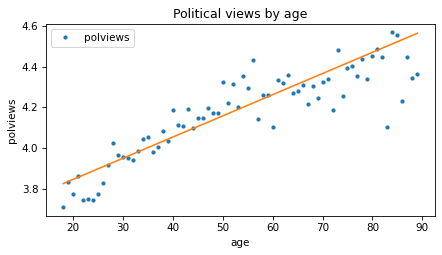

In [77]:
means_age.plot(style='.')
plt.plot(fit_x, fit_y)

decorate(xlabel=predictor, ylabel=response, title='Political views by age')

Based on these results, it seems like people might get more conservative as they get older, but let's also see if there's a relationship with year of birth -- that is, `cohort`.

But first, let's put the steps we just followed into a function.

In [129]:
def fit_model(df, response, predictors, fit_x):
    # group means by the first predictor
    print(predictors[0])
    means = df.groupby(predictors[0])[response].mean()

    # response and design matrix
    y = df[response]
    X = add_constant(df[predictors])

    # least squares fit
    beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')

    # fitted values for new X
    fit_y = add_constant(fit_x) @ beta

    # condition number of design matrix
    cond_number = np.linalg.cond(X)

    return RegressionResult(means, cond_number, rank, beta, fit_y)

`fit_model` takes as a parameters the `DataFrame`, the response variable, a list of predictors, and a range of `x` values where it should evaluate the fitted line.

It uses `groupby` to compute the average of the response variable as a function of the first predictor.

Then it extracts `y`, makes the design matrix, `X`, and computes the least squared fit.

It evaluates the fitted line over the given range, `fit_x`.

It computes the condition number of `X`, which I'll explain soon.

And it returns all of the results in a `RegressionResult` object.

`RegressionResult` is a `dataclass` which is a Python object that contains a specified set of attributes.

In [130]:
from dataclasses import dataclass

@dataclass
class RegressionResult:
    means: np.ndarray
    cond_number: float
    rank: int
    beta: np.ndarray
    fit_y: np.ndarray

Here's how we can use this function to compute a least squares fit of `polviews` as a function of `cohort`, evaluated over the range of birth years from 1880 to 2010.

In [131]:
predictor = 'cohort'
fit_x = np.arange(1880, 2010)
result = fit_model(subset, response, [predictor], fit_x)
result.rank, result.cond_number

cohort


(2, 174322.2522)

The rank of the design matrix is `2`, as expected, and the condition number is ...

TODO: talk about condition numbers

The following function takes the regression results and plots the fitted line along with the data.

In [132]:
color_map = {
    'age': 'C0',
    'year': 'C2',
    'cohort': 'C4',
}

def plot_result(response, predictor, result, fit_x):
    result.means.plot(style='.', color=color_map[predictor])
    plt.plot(fit_x, result.fit_y, color='C1')

    decorate(xlabel=predictor, 
             ylabel=response, 
             title=f'{response} by {predictor}')

Here's what the results look like for `polviews` as a function of `cohort`.

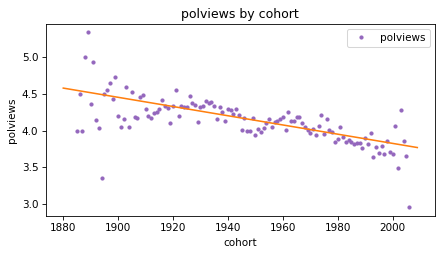

In [133]:
plot_result(response, predictor, result, fit_x)

The slope of the line is negative, which means that people born earlier said they were more conservative, when they were interviewed, than people born later, on average.

Based on the results so far, we can't tell whether people get more conservative as they age, or whether other people are more conservative because they were born earlier.
We'll come back to this question, but first let's look at the third predictor, `year`.

## Condition Number

So far computed least squares fits with `age` and `cohort` as predictors.
Now let's do the same with `year`.
We'll see that a straight line doesn't fit the data well, so we'll try fitting a parabola.
The first attempt will fail, but we'll diagnose the problem and fix it.

Here's the least squares fit of `polviews` as a function of `year`.

In [134]:
predictor = 'year'
fit_x = np.arange(1970, 2025)
result = fit_model(subset, response, [predictor], fit_x)
result.rank, np.log10(result.cond_number)

year


(2, 5.4187)

And here's the fitted line along with the data.

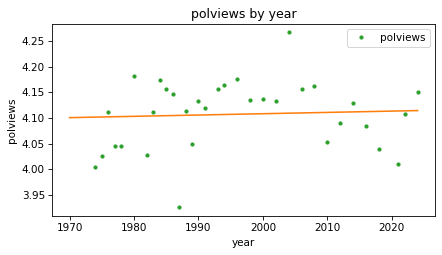

In [135]:
plot_result(response, predictor, result, fit_x)

The line is almost flat, which suggests that there is little or no change over time, but we can see that the line does not fit the data very well.
If there is a relationship between `polviews` and `year`, it seems to be **nonlinear**, increasing until some time between 1990 and 2000, and decreasing afterward.

Instead of fitting a straight line to the data, we can fit a parabola.
First we'll compute a new column that contains the values of `year` squared.

In [136]:
subset['year2'] = subset['year'] ** 2

Next we'll run a regression with `year` and `year2` as predictors.
Because we have two predictors, we'll need `fit_X` to be a matrix with two columns.
The first contains a range of dates from 1970 to 2024; the second contains those values squared.

In [143]:
fit_x0 = np.arange(1974, 2025)
fit_x1 = fit_x0 ** 2
fit_X = np.column_stack([fit_x0, fit_x1])

Now we can compute a least squares with with two predictors.

In [144]:
predictors = ['year', 'year2']
result = fit_model(subset, response, predictors, fit_X)
result.rank, np.log10(result.cond_number)

year


(3, 6.4290)

The rank is `3` now, because the design matrix contains two predictors and a column of ones.

And here's what the fitted line looks like.

In [145]:
result.fit_y

array([2.0294, 2.0276, 2.0259, 2.0241, 2.0223, 2.0206, 2.0188, 2.017 ,
       2.0152, 2.0134, 2.0117, 2.0099, 2.0081, 2.0063, 2.0045, 2.0027,
       2.001 , 1.9992, 1.9974, 1.9956, 1.9938, 1.992 , 1.9902, 1.9884,
       1.9866, 1.9848, 1.983 , 1.9812, 1.9794, 1.9776, 1.9758, 1.974 ,
       1.9722, 1.9704, 1.9686, 1.9668, 1.965 , 1.9632, 1.9614, 1.9596,
       1.9577, 1.9559, 1.9541, 1.9523, 1.9505, 1.9487, 1.9468, 1.945 ,
       1.9432, 1.9414, 1.9396])

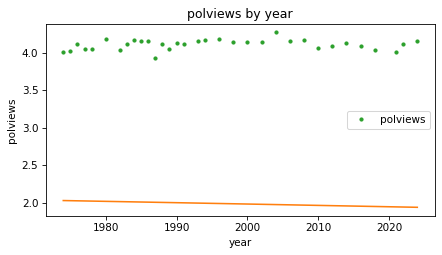

In [147]:
plot_result(response, predictors[0], result, fit_x0)

Clearly, something has gone wrong.

In [89]:
subset['year2'] = (subset['year'] - 2000) ** 2

In [90]:
fit_x0 = np.arange(1970, 2024)
fit_x1 = (fit_x0 - 2000) ** 2
fit_X = np.column_stack([fit_x0, fit_x1])

In [91]:
predictors = ['year', 'year2']
result = fit_model(subset, response, predictors, fit_X)
result.rank, np.log10(result.cond_number)

(3, 5.4218)

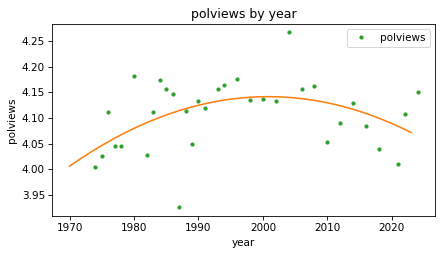

In [92]:
plot_result(response, predictors[0], result, fit_x0)

## Multiple Regression

In [93]:
predictors = ['age', 'cohort']
fit_x0 = np.arange(18, 90)

cohorts = [1920, 1960, 2000]
fits = {}

for cohort in cohorts:
    fit_x1 = np.full_like(fit_x0, cohort)
    fit_X = np.column_stack([fit_x0, fit_x1])

    result = fit_model(subset, response, predictors, fit_X)
    fits[cohort] = result.fit_y

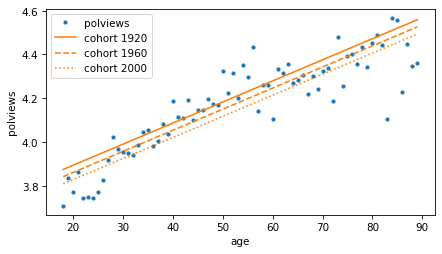

In [94]:
means_age.plot(style='.', color='C0')
style_map = dict(zip(cohorts, ['-', '--', ':']))
   
for cohort, fit_y in fits.items():
    plt.plot(fit_x0, fit_y, style_map[cohort], color='C1', label=f'cohort {cohort}')

decorate(xlabel=predictors[0], ylabel=response)

In [95]:
predictors = ['age', 'cohort', 'year']
fit_x0 = np.array([18])
fit_x1 = np.full_like(fit_x0, 2000)
fit_x2 = np.full_like(fit_x0, 2018)
fit_X = np.column_stack([fit_x0, fit_x1, fit_x2])

result = fit_model(subset, response, predictors, fit_X)
result.rank, np.log10(result.cond_number)

(4, 5.5754)

In [96]:
result.fit_y

array([3.8119])

In [97]:
result.beta

array([ 5.2298,  0.0224,  0.012 , -0.0128])

In [98]:
def resample(df, seed):
    return df.sample(len(df), replace=True, random_state=seed)

In [99]:
betas = []
fits = []
for seed in range(5):
    sample = resample(subset, seed)
    result = fit_model(sample, response, predictors, fit_X)
    betas.append(result.beta)
    fits.append(result.fit_y[0])
    
df = pd.DataFrame(betas, columns=['intercept', 'age', 'cohort', 'year'])
df['fit'] = fits
df

,intercept,age,cohort,year,fit
0,5.7651,-0.0016,-0.0121,0.0111,3.8055
1,6.1335,0.0491,0.0389,-0.0401,3.8100
2,5.7895,0.0756,0.0650,-0.0661,3.8014
3,5.3610,0.0555,0.0448,-0.0457,3.7996
4,4.4004,0.0673,0.0572,-0.0576,3.8327


## Trilateration

In [ ]:
import numpy as np

def trilateration_algebraic(beacons, ranges, ref_idx=0):
    """
    Algebraic LS trilateration in 2D.
    beacons: (m,2) array of [xi, yi]
    ranges:  (m,)  array of ri
    ref_idx: index k to use as reference equation
    Returns: x_hat, y_hat
    """
    C = np.asarray(beacons, float)
    r = np.asarray(ranges, float)
    k = ref_idx

    idx = [i for i in range(len(C)) if i != k]
    xi, yi = C[idx, 0], C[idx, 1]
    xk, yk = C[k, 0], C[k, 1]
    ri2, rk2 = r[idx]**2, r[k]**2

    A = np.column_stack([2*(xk - xi), 2*(yk - yi)])
    b = ri2 - rk2 + xk**2 - xi**2 + yk**2 - yi**2

    # LS solve via QR/SVD under the hood
    sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    return sol[0], sol[1]

def trilateration_refine_geometric(beacons, ranges, p0, steps=5, lam=0.0):
    """
    Few Gauss–Newton / LM refinement steps for geometric LS.
    lam=0 gives Gauss–Newton; lam>0 gives Levenberg–Marquardt damping.
    """
    p = np.array(p0, float)
    C = np.asarray(beacons, float)
    r = np.asarray(ranges, float)

    for _ in range(steps):
        d = np.linalg.norm(p - C, axis=1)
        e = d - r
        # Jacobian m x 2
        J = (p - C) / d[:, None]
        # Solve (J^T J + lam I) Δ = -J^T e
        JTJ = J.T @ J
        g = J.T @ e
        H = JTJ + lam * np.eye(2)
        delta = -np.linalg.solve(H, g)
        p = p + delta
        if np.linalg.norm(delta) < 1e-9:
            break
    return p


In [ ]:
# Example beacons & noisy ranges
beacons = np.array([[0.,0.], [10.,0.], [0.,10.], [10.,10.]])
true_p = np.array([4.2, 6.5])
ranges = np.linalg.norm(beacons - true_p, axis=1) + 0.2*np.random.randn(4)

In [ ]:
# Algebraic LS (initializer)
p0 = trilateration_algebraic(beacons, ranges, ref_idx=0)
p0

In [ ]:
# Geometric refinement (few tiny 2x2 solves)
p_hat = trilateration_refine_geometric(beacons, ranges, p0, steps=6, lam=1e-3)
p_hat

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)